# Overview
This notebook contains my work for using regression in predicting horsepower.

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import model

# MVP
First up is the MVP. I'm only using boost PSI and fuel octane as features here. Next iterations will include more features from the car_info.csv 'specs' column.

## Preparation

In [2]:
# acquire, prep, split, and scale data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prep_model_MVP()

In [3]:
# check work
X_validate

array([[0.06685237, 0.1       ],
       [0.09749304, 0.1       ],
       [0.05571031, 0.2       ],
       ...,
       [0.05849582, 0.1       ],
       [0.08077994, 0.1       ],
       [0.07799443, 0.15      ]])

## Generating Predictions

In [4]:
# build, fit model
lm = LinearRegression(normalize=True).fit(X_train, y_train)

In [5]:
# generate model predictions
train_preds = pd.DataFrame(lm.predict(X_train), columns=['OLS'])
validate_preds = pd.DataFrame(lm.predict(X_validate), columns=['OLS'])
# generate mean baseline
baseline = y_train.mean()
train_preds['baseline'] = baseline
validate_preds['baseline'] = baseline

In [6]:
train_preds.head()

,OLS,baseline
0,303.562574,328.526646
1,406.822696,328.526646
2,309.399283,328.526646
3,321.072701,328.526646
4,321.072701,328.526646


In [7]:
validate_preds.head()

,OLS,baseline
0,311.588049,328.526646
1,319.613523,328.526646
2,322.310979,328.526646
3,307.940105,328.526646
4,415.577759,328.526646


## Evaluation of Ordinary Least Squares (OLS) Model
### Residuals

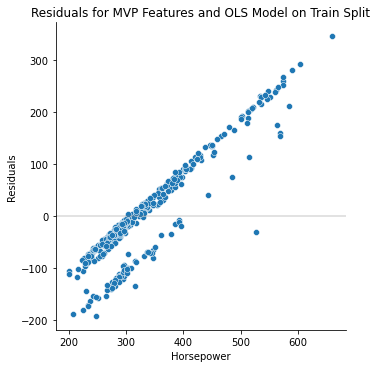

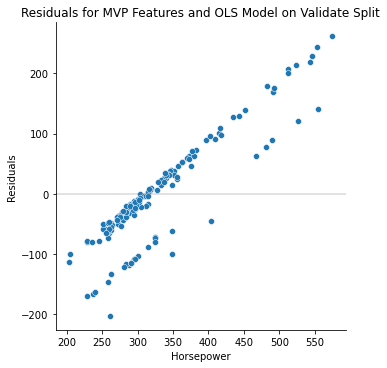

In [8]:
# calculate residuals
train_preds['residuals'] = y_train - train_preds['OLS']
validate_preds['residuals'] = y_validate - validate_preds['OLS']

# plot residuals for train split
sns.relplot(x=y_train, y=train_preds['residuals'])
plt.title('Residuals for MVP Features and OLS Model on Train Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

# plot residuals for validate split
sns.relplot(x=y_validate, y=validate_preds['residuals'])
plt.title('Residuals for MVP Features and OLS Model on Validate Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

As you can see, boost PSI and fuel octane do not tell the whole story of a car's horsepower. Once we've completed the MVP, we can dig deeper into feature engineering to reduce these residuals.

### RMSE and Other Error Metrics
**Train Split Metrics**

In [9]:
# OLS train SSE, ESS, TSS, MSE, RMSE
train_sse = round(mean_squared_error(y_train, train_preds['OLS']) * len(y_train), 2)
train_ess = round(sum((train_preds['OLS'] - y_train.mean())**2), 2)
train_tss = round(train_ess + train_sse, 2)
train_mse = round(mean_squared_error(y_train, train_preds['OLS']), 2)
train_rmse = round(train_mse ** 0.5, 2)

print('Sum of Squared Errors (SSE):', train_sse)
print('Explained Sum of Squares (ESS):', train_ess)
print('Total Sum of Squares (TSS):', train_tss)
print('Mean Squared Error (MSE):', train_mse)
print('Root Mean Squared Error (RMSE):', train_rmse)

Sum of Squared Errors (SSE): 8721778.89
Explained Sum of Squares (ESS): 1599328.01
Total Sum of Squares (TSS): 10321106.9
Mean Squared Error (MSE): 6617.43
Root Mean Squared Error (RMSE): 81.35


**Validate Split Metrics**

In [10]:
# baseline error on validate split
baseline_sse = round(mean_squared_error(y_validate, validate_preds['baseline']) * len(y_validate), 2)
baseline_ess = round(sum((validate_preds['baseline'] - y_validate.mean())**2), 2)
baseline_tss = round(baseline_ess + baseline_sse, 2)
baseline_mse = round(mean_squared_error(y_validate, validate_preds['baseline']), 2)
baseline_rmse = round(baseline_mse ** 0.5, 2)

# OLS validate SSE, ESS, TSS, MSE, RMSE
validate_sse = round(mean_squared_error(y_validate, validate_preds['OLS']) * len(y_validate), 2)
validate_ess = round(sum((validate_preds['OLS'] - y_validate.mean())**2), 2)
validate_tss = round(validate_ess + validate_sse, 2)
validate_mse = round(mean_squared_error(y_validate, validate_preds['OLS']), 2)
validate_rmse = round(validate_mse ** 0.5, 2)

In [11]:
# print baseline errors for validate split
print('------- Baseline on Validate - Errors -------')
print('Sum of Squared Errors (SSE):', baseline_sse)
print('Explained Sum of Squares (ESS):', baseline_ess)
print('Total Sum of Squares (TSS):', baseline_tss)
print('Mean Squared Error (MSE):', baseline_mse)
print('Root Mean Squared Error (RMSE):', baseline_rmse)

# print OLS errors for validate split
print('------- OLS on Validate - Errors --------')
print('Sum of Squared Errors (SSE):', validate_sse)
print('Explained Sum of Squares (ESS):', validate_ess)
print('Total Sum of Squares (TSS):', validate_tss)
print('Mean Squared Error (MSE):', validate_mse)
print('Root Mean Squared Error (RMSE):', validate_rmse)

------- Baseline on Validate - Errors -------
Sum of Squared Errors (SSE): 6381829.61
Explained Sum of Squares (ESS): 51444.47
Total Sum of Squares (TSS): 6433274.08
Mean Squared Error (MSE): 8057.87
Root Mean Squared Error (RMSE): 89.77
------- OLS on Validate - Errors --------
Sum of Squared Errors (SSE): 5217891.75
Explained Sum of Squares (ESS): 1015106.68
Total Sum of Squares (TSS): 6232998.43
Mean Squared Error (MSE): 6588.25
Root Mean Squared Error (RMSE): 81.17


### R^2 Explained Variance Score
**Train Split Explained Variance**

In [12]:
# OLS train r2
train_r2 = train_ess / train_tss
print('R-squared = ',round(train_r2,3))
print("Percent of variance in y explained by x = ", round(train_r2*100,1), "%")

R-squared =  0.155
Percent of variance in y explained by x =  15.5 %


**Validate Split Explained Variance**

In [13]:
# baseline validate r2
baseline_r2 = baseline_ess / baseline_tss
print('R-squared = ',round(baseline_r2, 3))
print("Percent of variance in y explained by x = ", round(baseline_r2 * 100, 1), "%")

R-squared =  0.008
Percent of variance in y explained by x =  0.8 %


In [14]:
# OLS validate r2
validate_r2 = validate_ess / validate_tss
print('R-squared = ',round(validate_r2, 3))
print("Percent of variance in y explained by x = ", round(validate_r2 * 100, 1), "%")

R-squared =  0.163
Percent of variance in y explained by x =  16.3 %


## MVP Takeaways
- Using only the boost PSI and fuel octane of each car, our OLS model:
    * Had an RMSE of 81 horsepower (Baseline: 90 horsepower)
    * Had an explained variance of 16% (Baseline: 1%)

**Therefore, our OLS model performed significantly better than the baseline.**

In next iterations, we will add more features and models to try to improve our predictions.

# Post-MVP Modeling
We imputed nulls in boost PSI and fuel octane, and we added a feature indicating the stock horsepower of the car. We created a feature called tuned_cpu that we will not use based on results from post-MVP exploration.

In [15]:
# acquire, prep, split, and scale data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prep_model()

In [16]:
X_validate

array([[0.47474747, 0.09189189, 0.17241379],
       [0.4040404 , 0.10540541, 0.20689655],
       [0.33333333, 0.06756757, 0.17241379],
       ...,
       [0.45656566, 0.12162162, 0.17241379],
       [0.48484848, 0.1027027 , 0.17241379],
       [0.4       , 0.10540541, 0.20689655]])

## Generating Predictions

In [17]:
# build, fit model
lm = LinearRegression(normalize=True).fit(X_train, y_train)

In [18]:
# generate model predictions
train_preds = pd.DataFrame(lm.predict(X_train), columns=['OLS'])
validate_preds = pd.DataFrame(lm.predict(X_validate), columns=['OLS'])
# generate mean baseline
baseline = y_train.mean()
train_preds['baseline'] = baseline
validate_preds['baseline'] = baseline

In [19]:
train_preds.head()

,OLS,baseline
0,317.104202,328.913505
1,330.427271,328.913505
2,334.655012,328.913505
3,475.070708,328.913505
4,284.138805,328.913505


In [20]:
validate_preds.head()

,OLS,baseline
0,318.719849,328.913505
1,301.888066,328.913505
2,245.116738,328.913505
3,332.028088,328.913505
4,327.466589,328.913505


## Evaluation of Ordinary Least Squares (OLS) Model
### Residuals

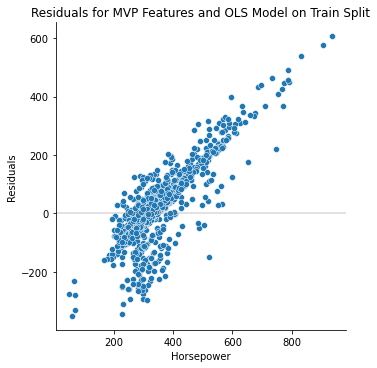

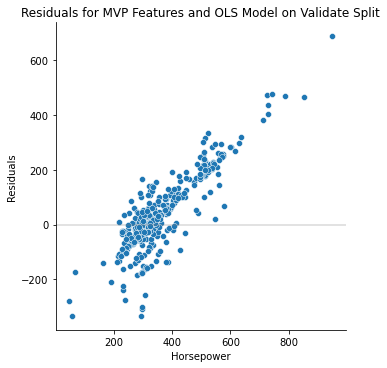

In [21]:
# calculate residuals
train_preds['residuals'] = y_train - train_preds['OLS']
validate_preds['residuals'] = y_validate - validate_preds['OLS']

# plot residuals for train split
sns.relplot(x=y_train, y=train_preds['residuals'])
plt.title('Residuals for MVP Features and OLS Model on Train Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

# plot residuals for validate split
sns.relplot(x=y_validate, y=validate_preds['residuals'])
plt.title('Residuals for MVP Features and OLS Model on Validate Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

As you can see, boost PSI, fuel octane, and stock horsepower do not tell the whole story of a car's horsepower. In future iterations we can dig deeper into feature engineering to reduce these residuals further.

### RMSE and Other Error Metrics
**Train Split Metrics**

In [22]:
# OLS train SSE, ESS, TSS, MSE, RMSE
train_sse = round(mean_squared_error(y_train, train_preds['OLS']) * len(y_train), 2)
train_ess = round(sum((train_preds['OLS'] - y_train.mean())**2), 2)
train_tss = round(train_ess + train_sse, 2)
train_mse = round(mean_squared_error(y_train, train_preds['OLS']), 2)
train_rmse = round(train_mse ** 0.5, 2)

print('Sum of Squared Errors (SSE):', train_sse)
print('Explained Sum of Squares (ESS):', train_ess)
print('Total Sum of Squares (TSS):', train_tss)
print('Mean Squared Error (MSE):', train_mse)
print('Root Mean Squared Error (RMSE):', train_rmse)

Sum of Squared Errors (SSE): 10462265.37
Explained Sum of Squares (ESS): 11006596.12
Total Sum of Squares (TSS): 21468861.49
Mean Squared Error (MSE): 4719.11
Root Mean Squared Error (RMSE): 68.7


**Validate Split Metrics**

In [23]:
# baseline error on validate split
baseline_sse = round(mean_squared_error(y_validate, validate_preds['baseline']) * len(y_validate), 2)
baseline_ess = round(sum((validate_preds['baseline'] - y_validate.mean())**2), 2)
baseline_tss = round(baseline_ess + baseline_sse, 2)
baseline_mse = round(mean_squared_error(y_validate, validate_preds['baseline']), 2)
baseline_rmse = round(baseline_mse ** 0.5, 2)

# OLS validate SSE, ESS, TSS, MSE, RMSE
validate_sse = round(mean_squared_error(y_validate, validate_preds['OLS']) * len(y_validate), 2)
validate_ess = round(sum((validate_preds['OLS'] - y_validate.mean())**2), 2)
validate_tss = round(validate_ess + validate_sse, 2)
validate_mse = round(mean_squared_error(y_validate, validate_preds['OLS']), 2)
validate_rmse = round(validate_mse ** 0.5, 2)

In [24]:
# print baseline errors for validate split
print('------- Baseline on Validate - Errors -------')
print('Sum of Squared Errors (SSE):', baseline_sse)
print('Explained Sum of Squares (ESS):', baseline_ess)
print('Total Sum of Squares (TSS):', baseline_tss)
print('Mean Squared Error (MSE):', baseline_mse)
print('Root Mean Squared Error (RMSE):', baseline_rmse)

# print OLS errors for validate split
print('------- OLS on Validate - Errors --------')
print('Sum of Squared Errors (SSE):', validate_sse)
print('Explained Sum of Squares (ESS):', validate_ess)
print('Total Sum of Squares (TSS):', validate_tss)
print('Mean Squared Error (MSE):', validate_mse)
print('Root Mean Squared Error (RMSE):', validate_rmse)

------- Baseline on Validate - Errors -------
Sum of Squared Errors (SSE): 12750809.13
Explained Sum of Squares (ESS): 5427.23
Total Sum of Squares (TSS): 12756236.36
Mean Squared Error (MSE): 9579.87
Root Mean Squared Error (RMSE): 97.88
------- OLS on Validate - Errors --------
Sum of Squared Errors (SSE): 6419811.37
Explained Sum of Squares (ESS): 6416793.7
Total Sum of Squares (TSS): 12836605.07
Mean Squared Error (MSE): 4823.3
Root Mean Squared Error (RMSE): 69.45


### R^2 Explained Variance Score
**Train Split Explained Variance**

In [25]:
# OLS train r2
train_r2 = train_ess / train_tss
print('R-squared = ',round(train_r2,3))
print("Percent of variance in y explained by x = ", round(train_r2*100,1), "%")

R-squared =  0.513
Percent of variance in y explained by x =  51.3 %


**Validate Split Explained Variance**

In [26]:
# baseline validate r2
baseline_r2 = baseline_ess / baseline_tss
print('R-squared = ',round(baseline_r2, 3))
print("Percent of variance in y explained by x = ", round(baseline_r2 * 100, 1), "%")

R-squared =  0.0
Percent of variance in y explained by x =  0.0 %


In [27]:
# OLS validate r2
validate_r2 = validate_ess / validate_tss
print('R-squared = ',round(validate_r2, 3))
print("Percent of variance in y explained by x = ", round(validate_r2 * 100, 1), "%")

R-squared =  0.5
Percent of variance in y explained by x =  50.0 %


## Post-MVP Takeaways
- Using boost PSI, fuel octane, and stock horsepower of each car, our OLS model:
    * Had an RMSE of 69 horsepower (Baseline: 98 horsepower)
    * Had an explained variance of 50% (Baseline: 0%)

**Therefore, our OLS model performed significantly better than the baseline.**

## More Models
With these three features, we've beaten the baseline significantly. Now, we will use multiple models and hyperparameter combinations to try to improve our RMSE and R^2 value even further on train and validate splits. After we've chosen our best algorithm and hyperparameter combination, we will evaluate our best model on the test split, which has been sequestered specifically for this purpose.

In [28]:
# prepare train and validate for regression shotgun
y_train = pd.DataFrame(y_train).rename(columns={'hp':'actuals'})
y_validate = pd.DataFrame(y_validate).rename(columns={'hp':'actuals'})

In [29]:
# run the regression shotgun
y_train, y_validate = model.regression_shotgun(X_train, y_train, X_validate, y_validate)

In [30]:
# check work
y_validate

,actuals,mean_bl,median_bl,ols_preds,lars_0.0001_preds,lars_0.001_preds,lars_0.01_preds,lars_0.1_preds,lars_1_preds,lars_10_preds,...,glm_p3a0.1_preds,glm_p3a1_preds,glm_p3a10_preds,glm_p3a100_preds,glm_p3a1000_preds,lm_pf_2_preds,lm_pf_3_preds,lm_pf_4_preds,lm_pf_5_preds,lm_pf_6_preds
1285,299.0,326.894207,304.0,318.719849,318.722038,318.741742,318.938786,320.909225,329.924514,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,300.894291,297.472794,291.735217,295.641207,296.937087
2780,296.0,326.894207,304.0,301.888066,301.890030,301.907704,302.084442,303.851821,322.509652,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,305.371334,291.498907,285.887752,288.357145,290.370292
1700,318.0,326.894207,304.0,245.116738,245.126143,245.210785,246.057209,254.521444,315.094790,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,239.727767,230.479723,251.344555,244.936050,241.293144
1552,276.0,326.894207,304.0,332.028088,332.027821,332.025419,332.001398,331.761195,329.924514,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,323.281844,312.888260,303.973276,308.319957,306.736114
1748,353.0,326.894207,304.0,327.466589,327.467541,327.476116,327.561859,328.419290,330.983780,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,315.092154,312.439877,307.789061,311.479359,314.090046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,250.0,326.894207,304.0,263.728137,263.734885,263.795621,264.402976,270.476530,317.848881,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,275.147622,264.395283,281.114550,274.452621,267.876056
1555,305.0,326.894207,304.0,402.906499,402.895118,402.792681,401.768311,391.524618,329.924514,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,360.997928,351.803935,354.135466,346.502047,346.335894
4054,318.0,326.894207,304.0,327.253308,327.252705,327.247277,327.193001,326.650235,328.017835,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,335.764140,337.376115,334.254551,329.568420,336.116185
820,313.0,326.894207,304.0,328.946930,328.947576,328.953397,329.011599,329.593627,330.983780,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,318.789299,316.277478,312.209646,315.523115,318.834680


In [31]:
# check RMSE and R^2 value for each model on train and validate
running_df = model.y_df_RMSE_r2(y_train, y_validate)

In [32]:
# check results
running_df.sort_values(by='Validate_r2', ascending=False).head()

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
45,lm_pf_4_preds,50.659167,60.861762,0.734984,0.613175
43,lm_pf_2_preds,58.427301,64.294286,0.647476,0.568312
27,glm_p2a0.0001_preds,92.670653,67.384360,0.113168,0.525820
44,lm_pf_3_preds,54.328950,67.447989,0.695197,0.524924
19,glm_p1a0.0001_preds,69.064539,68.910583,0.507431,0.504097


## More Models - Takeaways
After creating many models with various hyperparameter combinations, our best model is the Polynomial Regression model with two degrees. It is less than 10% overfit while still maintaining a decent RMSE.

- **Best model: Polynomial Regression**
- **RMSE: 64 horsepower**
- **R^2 Explained Variance: 57%**

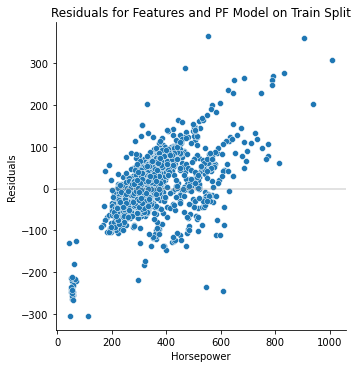

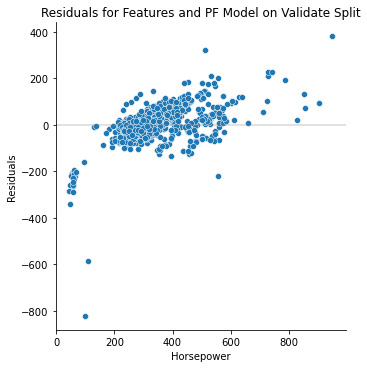

In [33]:
# show residuals for best model
# calculate residuals
pf_train_residuals = y_train['actuals'] - y_train['lm_pf_2_preds']
pf_validate_residuals = y_validate['actuals'] - y_validate['lm_pf_2_preds']

# plot residuals for train split
sns.relplot(x=y_train['actuals'], y=pf_train_residuals)
plt.title('Residuals for Features and PF Model on Train Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

# plot residuals for validate split
sns.relplot(x=y_validate['actuals'], y=pf_validate_residuals)
plt.title('Residuals for Features and PF Model on Validate Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

# Best Model on Test Split
Now that we've chosen our best model, we will evaluate our model on the test split.

In [34]:
lm = LinearRegression(normalize=True) # Create linear regression model
# Create polynomial variables
X_train_pf = PolynomialFeatures(degree=2).fit_transform(X_train)
X_test_pf = PolynomialFeatures(degree=2).fit(X_train).transform(X_test)
# Make predictions on polynomial variables
train_predictions = lm.fit(X_train_pf, y_train.actuals).predict(X_train_pf)
test_predictions = lm.fit(X_train_pf, y_train.actuals).predict(X_test_pf)

In [35]:
# Evaluate!
rmse_train = mean_squared_error(y_train.actuals, train_predictions) ** 0.5
rmse_test = mean_squared_error(y_test, test_predictions) ** 0.5
r2_train = r2_score(y_train.actuals, train_predictions)
r2_test = r2_score(y_test, test_predictions)

In [36]:
print(f'Train: RMSE of {int(rmse_train)} horsepower, explained variance of {round(r2_train * 100, 1)}%.')
print(f'Test: RMSE of {int(rmse_test)} horsepower, explained variance of {round(r2_test * 100, 1)}%.')

Train: RMSE of 58 horsepower, explained variance of 64.7%.
Test: RMSE of 69 horsepower, explained variance of 47.1%.


# Modeling Takeaways
## Features
### Stock Horsepower, Boost PSI, and Fuel Octane
## Baseline
### RMSE of 98 Horsepower, R^2 of 0%
## Our Best Model: Polynomial Features Linear Regression with 2 Degrees
### R^2 Explained Variance: 52% on unseen data
### RMSE: 67 Horsepower